Using 'DeepFashion' Dataset for Test Purposes: (Category and Attribute Prediction Benchmark)

- https://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html


DISC2021 Image Similarity Dataset:
- https://sites.google.com/view/isc2021/dataset

**Given a picture, find most similar 3 pictures from the set**

*1- Load and Preprocess Images*

In [2]:
import os
import numpy as np
import torch
import clip
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Directory containing images
image_dir = 'test_images_fashion'

# Load and preprocess images
def load_images(image_dir):
    image_list = []
    file_names = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(image_dir, filename)
            img = Image.open(img_path).convert("RGB")
            image_list.append(img)
            file_names.append(filename)
    return image_list, file_names

images, file_names = load_images(image_dir)

# Display number of loaded images
print(f"Loaded {len(images)} images.")

Loaded 635 images.


*2- Get Embeddings for the Image File*

In [3]:
# Load pre-trained CLIP model
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Extract embeddings using CLIP
def get_embeddings(model, preprocess, images):
    image_tensors = [preprocess(img).unsqueeze(0).to(device) for img in images]
    image_features = []
    with torch.no_grad():
        for image_tensor in image_tensors:
            image_features.append(model.encode_image(image_tensor))
    embeddings = torch.cat(image_features).numpy()
    return embeddings

embeddings = get_embeddings(model, preprocess, images)
print("Embeddings shape:", embeddings.shape)

Embeddings shape: (635, 512)


*3- Find most Similar images among the image file with the Given Image*

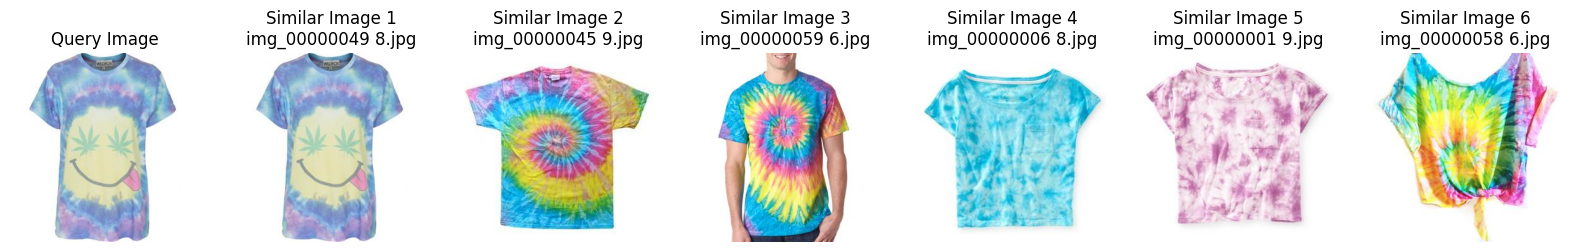

In [4]:
# Function to find the most similar images
def find_most_similar_images(query_img_path, model, preprocess, embeddings, images, file_names, top_k=6):
    query_img = Image.open(query_img_path).convert("RGB")
    query_tensor = preprocess(query_img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        query_embedding = model.encode_image(query_tensor).numpy()
    
    similarities = cosine_similarity(query_embedding, embeddings).flatten()
    top_k_indices = similarities.argsort()[-top_k:][::-1]
    
    # Display the most similar images
    fig, axes = plt.subplots(1, top_k + 1, figsize=(20, 5))
    
    # Display query image
    axes[0].imshow(query_img)
    axes[0].set_title("Query Image")
    axes[0].axis("off")
    
    for i, idx in enumerate(top_k_indices):
        similar_img = images[idx]
        axes[i + 1].imshow(similar_img)
        axes[i + 1].set_title(f"Similar Image {i+1}\n{file_names[idx]}")
        axes[i + 1].axis("off")
    
    plt.show()

# Path to the query image
query_image_path = 'test_images/test_image6.jpg'

# Find and display the most similar images
find_most_similar_images(query_image_path, model, preprocess, embeddings, images, file_names)

*4- Find most Similar images among the image file with the Given Text*

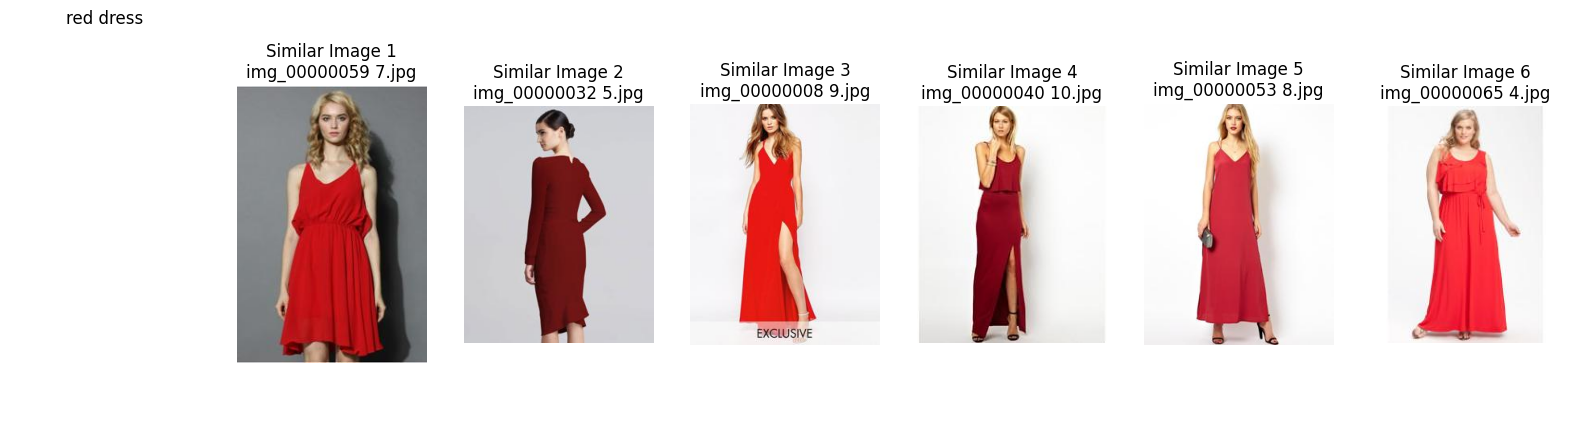

In [7]:
# Function to find the most similar images with text
def find_most_similar_images(query_text, model, embeddings, images, file_names, top_k=6):
    # Text preprocess
    text_inputs = clip.tokenize([query_text]).to(device)

    with torch.no_grad():
        query_embedding = model.encode_text(text_inputs).cpu().numpy()
    
    similarities = cosine_similarity(query_embedding, embeddings).flatten()
    top_k_indices = similarities.argsort()[-top_k:][::-1]
    
    # Display the most similar images
    fig, axes = plt.subplots(1, top_k + 1, figsize=(20, 5))
    
    # Display query text
    axes[0].set_title(query_text)
    axes[0].axis("off")
    
    for i, idx in enumerate(top_k_indices):
        similar_img = images[idx]
        axes[i + 1].imshow(similar_img)
        axes[i + 1].set_title(f"Similar Image {i+1}\n{file_names[idx]}")
        axes[i + 1].axis("off")
    
    plt.show()

# Example query text
query_text = 'red dress'

# Find and display the most similar images
find_most_similar_images(query_text, model, embeddings, images, file_names)

*4- Find most Similar images among the image file with the Given Text, with Positive and Negative Prompts*

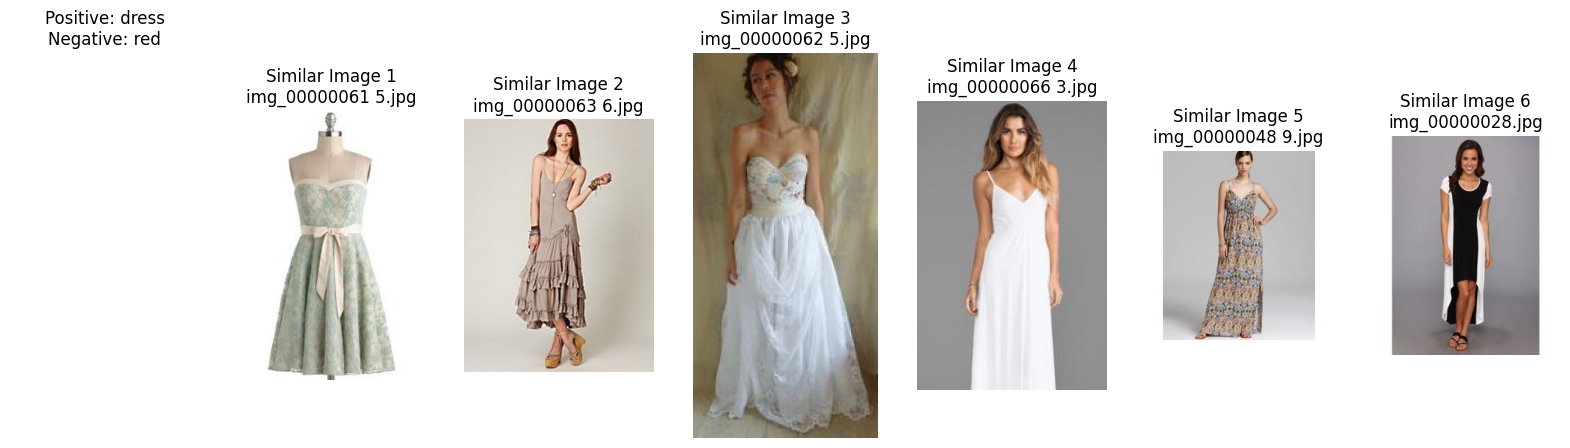

In [22]:
# Function to find the most similar images with positive and negative conditions
def find_most_similar_images(query_text, negative_text, model, embeddings, images, file_names, top_k=6):
    # Text preprocess
    text_inputs_positive = clip.tokenize([query_text]).to(device)
    text_inputs_negative = clip.tokenize([negative_text]).to(device)

    with torch.no_grad():
        query_embedding_positive = model.encode_text(text_inputs_positive).cpu().numpy()
        query_embedding_negative = model.encode_text(text_inputs_negative).cpu().numpy()
    
    # Combine positive and negative embeddings
    query_embedding = query_embedding_positive - query_embedding_negative
    
    similarities = cosine_similarity(query_embedding, embeddings).flatten()
    top_k_indices = similarities.argsort()[-top_k:][::-1]
    
    # Display the most similar images
    fig, axes = plt.subplots(1, top_k + 1, figsize=(20, 5))
    
    # Display query texts
    axes[0].set_title(f"Positive: {query_text}\nNegative: {negative_text}")
    axes[0].axis("off")
    
    for i, idx in enumerate(top_k_indices):
        similar_img = images[idx]
        axes[i + 1].imshow(similar_img)
        axes[i + 1].set_title(f"Similar Image {i+1}\n{file_names[idx]}")
        axes[i + 1].axis("off")
    
    plt.show()

# Example query text and negative text
query_text = 'dress'
negative_text = 'red'

# Find and display the most similar images
find_most_similar_images(query_text, negative_text, model, embeddings, images, file_names)